# Introduction
Notebook to predict actions in video, and to score the accuracy of the model using a IOU-like method.

# Imports


In [1]:
from ops.dataset import TSNDataSet
from ops import dataset_config
from ops.models import TSN
from ops.transforms import *
from tools.vid2img import vid2jpg, convert_folder
from env_vars import VIDEOS_DIR, PREPROCESSED_DATA_ROOT, RAW_DATA_ROOT

import os
import glob
from pathlib import Path
import pickle

import time
import cv2
import numpy as np
import pandas as pd
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
import torch.nn.parallel
import torch.optim
from torch.nn import functional as F #for softmax 

# Functions

In [2]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    res = []
    for k in topk:
         correct_k = correct[:k].contiguous().view(-1).float().sum(0)
         res.append(correct_k.mul_(100.0 / batch_size))
    return res


def parse_shift_option_from_log_name(log_name):
    if 'shift' in log_name:
        strings = log_name.split('_')
        for i, s in enumerate(strings):
            if 'shift' in s:
                break
        return True, int(strings[i].replace('shift', '')), strings[i + 1]
    else:
        return False, None, None
    

def eval_video(video_data, net, this_test_segments, modality):
    net.eval()
    with torch.no_grad():
        i, data, label = video_data
        batch_size = label.numel()
        num_crop = test_crops
        if dense_sample:
            num_crop *= 10  # 10 clips for testing when using dense sample

        if twice_sample:
            num_crop *= 2

        if modality == 'RGB':
            length = 3
        elif modality == 'Flow':
            length = 10
        elif modality == 'RGBDiff':
            length = 18
        else:
            raise ValueError("Unknown modality "+ modality)

        data_in = data.view(-1, length, data.size(2), data.size(3))
        if is_shift:
            data_in = data_in.view(batch_size * num_crop, this_test_segments, length, data_in.size(2), data_in.size(3))
        rst = net(data_in)
        rst = rst.reshape(batch_size, num_crop, -1).mean(1)

        if softmax:
            # take the softmax to normalize the output to probability
            rst = F.softmax(rst, dim=1)

        rst = rst.data.cpu().numpy().copy()

        if net.module.is_shift:
            rst = rst.reshape(batch_size, num_class)
        else:
            rst = rst.reshape((batch_size, -1, num_class)).mean(axis=1).reshape((batch_size, num_class))

        return i, rst, label

## Change these parameters as needed
Set your dataset_version, weights path (this_weights), source directory, and output directory

In [4]:
dataset_version = 'pc_101'

# set to the path to your model file
this_weights = f'checkpoint/'\
               f'20210710_TSM_ite_RGB_resnet50_shift8_blockres_avg_segment8_e150_{dataset_version}_dense/'\
                'checkpoint/ckpt.best.pth.tar'

#duration of clip to send to model for prediction
#this should represent the rough average length of your actions in the dataset.
# example: if your actions are an average of 3 seconds long, then set CLIP_DURATION = 3
CLIP_DURATION = 2 #seconds


# FOLDERS========================================================================================
# video locations for dividing video into clips for getting the predictions

source_dir = os.path.join(RAW_DATA_ROOT, 'ite_dataset', 'videos', 'UAT_Stitched_Test_Cases')
source_dir = "C:\\Users\\User1\\Desktop\\projects\\ITE_APAMS\\ite_dataset\\videos\\210304\\A"
video_paths = glob.glob(os.path.join(source_dir, '*.MP4'))


# Fixed param, where the ite_dataset is at
root_data_path = PREPROCESSED_DATA_ROOT

# folder to store the prediction .csv and video files
dt = time.strftime('%Y%m%d%H%M', time.localtime())
cwd = os.getcwd()
output_path = os.path.join(cwd, f'{dt}_{dataset_version}_output') #- used for just dense, full_res = False, test_crops=1

Path(output_path).mkdir(exist_ok=True)

# temp directory location for storing the split video from source_dir into 2s clips
tmp_dir = os.path.join(PREPROCESSED_DATA_ROOT, 'tmp')
Path(tmp_dir).mkdir(exist_ok=True)


In [5]:
video_paths

['C:\\Users\\User1\\Desktop\\projects\\ITE_APAMS\\ite_dataset\\videos\\210304\\A\\A_1.MP4',
 'C:\\Users\\User1\\Desktop\\projects\\ITE_APAMS\\ite_dataset\\videos\\210304\\A\\A_2.MP4',
 'C:\\Users\\User1\\Desktop\\projects\\ITE_APAMS\\ite_dataset\\videos\\210304\\A\\A_3.MP4']

## MODEL PARAMETERS
- Inferred by this_weights
- Set by User

In [6]:
#============================================================================================================#
# Fixed parameters based on the model trained
num_segments = 8

#============================================================================================================#
# Currently tested parameters that can be changed
# FOR A MODEL THAT IS TRAINED WITH DENSE_SAMPLE, MUST SET EITHER TO TRUE
dense_sample = True  # True 
twice_sample = False

#============================================================================================================#
# Parameters that were fixed throughout different models prediction (perhaps could be altered for performance)
# Are these training parameters as well?????
test_crops = 1  #1
full_res = False #False
this_test_segments = 8
#========================# Data Loading, Etc Parameters (changes based on computer, etc)==========================#
batch_size = 2
num_workers = 0

#============================================================================================================#
# Fixed parameters (either from parsing from this_weights, or not really changed)
is_shift, shift_div, shift_place = parse_shift_option_from_log_name(this_weights)
softmax = True
SOFTMAX_THRESH = 0.8

#============================================================================================================#
# Check for device
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"

# Load model

In [7]:
this_arch = this_weights.split('TSM_')[1].split('_')[2]
if 'RGB' in this_weights:
        modality = 'RGB'
else:
    modality = 'Flow'
    
num_class, train_list, val_list, root_path, prefix = dataset_config.return_dataset(root_data_path, 'ite',
                                                                                            modality, version = dataset_version)

net = TSN(num_class, this_test_segments if is_shift else 1, modality,
              base_model=this_arch,
              consensus_type='avg',
              img_feature_dim=256,
              pretrain='imagenet',
              is_shift=is_shift, shift_div=shift_div, shift_place=shift_place,
              non_local='_nl' in this_weights,
              )

if 'tpool' in this_weights:
    from ops.temporal_shift import make_temporal_pool
    make_temporal_pool(net.base_model, this_test_segments)  # since DataParallel

checkpoint = torch.load(this_weights, map_location=torch.device(dev))
checkpoint = checkpoint['state_dict']

# base_dict = {('base_model.' + k).replace('base_model.fc', 'new_fc'): v for k, v in list(checkpoint.items())}
base_dict = {'.'.join(k.split('.')[1:]): v for k, v in list(checkpoint.items())}
replace_dict = {'base_model.classifier.weight': 'new_fc.weight',
                'base_model.classifier.bias': 'new_fc.bias',
                }
for k, v in replace_dict.items():
    if k in base_dict:
        base_dict[v] = base_dict.pop(k)

net.load_state_dict(base_dict)

input_size = net.scale_size if full_res else net.input_size
if test_crops == 1:
    cropping = torchvision.transforms.Compose([
        GroupScale(net.scale_size),
        GroupCenterCrop(input_size),
    ])
elif test_crops == 3:  # do not flip, so only 5 crops
    cropping = torchvision.transforms.Compose([
        GroupFullResSample(input_size, net.scale_size, flip=False)
    ])
elif test_crops == 5:  # do not flip, so only 5 crops
    cropping = torchvision.transforms.Compose([
        GroupOverSample(input_size, net.scale_size, flip=False)
    ])
elif test_crops == 10:
    cropping = torchvision.transforms.Compose([
        GroupOverSample(input_size, net.scale_size)
    ])
else:
    raise ValueError("Only 1, 5, 10 crops are supported while we got {}".format(test_crops))

ite: 33 classes

    Initializing TSN with base model: resnet50.
    TSN Configurations:
        input_modality:     RGB
        num_segments:       8
        new_length:         1
        consensus_module:   avg
        dropout_ratio:      0.8
        img_feature_dim:    256
            
=> base model: resnet50
Adding temporal shift...
=> n_segment per stage: [8, 8, 8, 8]
=> Processing stage with 3 blocks residual
=> Using fold div: 8
=> Using fold div: 8
=> Using fold div: 8
=> Processing stage with 4 blocks residual
=> Using fold div: 8
=> Using fold div: 8
=> Using fold div: 8
=> Using fold div: 8
=> Processing stage with 6 blocks residual
=> Using fold div: 8
=> Using fold div: 8
=> Using fold div: 8
=> Using fold div: 8
=> Using fold div: 8
=> Using fold div: 8
=> Processing stage with 3 blocks residual
=> Using fold div: 8
=> Using fold div: 8
=> Using fold div: 8


C:\Users\User1\anaconda3\envs\ptcpu\lib\site-packages\torchvision\transforms\transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


# Preprocess data and create data loaders
Just like the training data, our input videos need to be converted to clips and then frames (images) first.
We will split the video into clips of equal length (determined by the CLIP_DURATION parameter).
These clips will then be converted into frames.
Then we will create a dataloader per-video, to be used for prediction later.

In [8]:
def get_video_properties(video_path):
    #get video properties
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)      # OpenCV2 version 2 used "CV_CAP_PROP_FPS"
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))   # float `width`
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) ) # float `height`
    cap.release()
    return fps, frame_count, width, height

def prepare_video(video_path, preprocess = True, dataloaders = True, del_clips = True):
    filename = os.path.basename(video_path)
    
    #get video properties
    fps, frame_count, width, height = get_video_properties(video_path)
    
    
    dest_dir = os.path.join(tmp_dir, filename)
    print(dest_dir)
    print(f'fps: {fps}, frame count: {frame_count}, clip duration: {CLIP_DURATION}, filename: {filename}')
    
    if preprocess:
        for i in range(0, int(frame_count/fps), int(CLIP_DURATION)):
            Path(dest_dir).mkdir(exist_ok=True)
            target_filepath = os.path.join(dest_dir, f'{i:04}_{filename}')
            
            #convert video to clips
            ffmpeg_extract_subclip(video_path, i, i + int(CLIP_DURATION), targetname=target_filepath)

        #convert clips to images
        convert_folder(dest_dir, dest_dir)
    
    #generate video file list
    video_folders_file = 'videofolder.txt'
    video_folders_filepath = os.path.join(dest_dir, video_folders_file)
    with open(video_folders_filepath, 'w+') as file:
        for folder in glob.glob(os.path.join(dest_dir, '*')):
            if not os.path.isdir(folder):
                continue
            num_images = len(glob.glob(os.path.join(folder, '*')))
            file.write(f'{folder},{num_images},{-1}\n')
            
    if del_clips:
        for p in glob.glob(os.path.join(dest_dir, '*.MP4')):
            os.remove(p)
            
    #prepare data loaders
    if dataloaders:
        print(f'net.input_mean: {net.input_mean}, net.input_std: {net.input_std}')
        data_loader = torch.utils.data.DataLoader(
                    TSNDataSet(root_path, video_folders_filepath, num_segments=num_segments,
                               new_length=1 if modality == "RGB" else 5,
                               modality=modality,
                               image_tmpl=prefix,
                               test_mode=True,
                               random_shift = False, #use consistent spacing between segments (frames)
                               transform=torchvision.transforms.Compose([
                                   cropping,
                                   Stack(roll=(this_arch in ['BNInception', 'InceptionV3'])),
                                   ToTorchFormatTensor(div=(this_arch not in ['BNInception', 'InceptionV3'])),
                                   GroupNormalize([0.485, 0.456, 0.406], [0.485, 0.456, 0.406]),
                               ]), dense_sample=dense_sample, twice_sample=twice_sample),
                    batch_size=batch_size, shuffle=False,
                    num_workers=num_workers, pin_memory=True,
            )
    else:
        data_loader = None
        
    return {'data_loader': data_loader, 'videofolder':video_folders_filepath, 'fps':fps, 'frame_count':frame_count, 'width': width, 'height':height}
    


In [9]:
video_dict = dict()
for video_path in video_paths:
    # if you have previously run this code and have the converted clips and frames in tmp_dir, then you can set preprocess=False
    video_dict[video_path] = prepare_video(video_path, preprocess = True, dataloaders = True, del_clips=False) 


C:\Users\User1\Desktop\projects\ITE_APAMS\ite_dataset\tmp\A_1.MP4
fps: 29.97002997002997, frame count: 1332, clip duration: 2, filename: A_1.MP4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ "

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:11<00:00,  1.88it/s]




net.input_mean: [0.485, 0.456, 0.406], net.input_std: [0.485, 0.456, 0.406]
=> Using dense sample for the dataset...
video number:22
C:\Users\User1\Desktop\projects\ITE_APAMS\ite_dataset\tmp\A_2.MP4
fps: 29.97002997002997, frame count: 2979, clip duration: 2, filename: A_2.MP4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.43it/s]




net.input_mean: [0.485, 0.456, 0.406], net.input_std: [0.485, 0.456, 0.406]
=> Using dense sample for the dataset...
video number:50
C:\Users\User1\Desktop\projects\ITE_APAMS\ite_dataset\tmp\A_3.MP4
fps: 29.97002997002997, frame count: 1382, clip duration: 2, filename: A_3.MP4
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
Moviepy - Running:
>>> "+ " ".

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:17<00:00,  1.35it/s]



net.input_mean: [0.485, 0.456, 0.406], net.input_std: [0.485, 0.456, 0.406]
=> Using dense sample for the dataset...
video number:23


# Predict

In [10]:
net = torch.nn.DataParallel(net.to(dev))
net.eval()
for video_path in video_paths:
    data_loader = video_dict[video_path]['data_loader']
    data_gen = enumerate(data_loader)
    this_rst_list = []
    label_list = []
    for i, (data, label) in data_gen:
        rst = eval_video((i, data, label), net, this_test_segments, modality)

        for l, r in zip(label, rst[1]): #unpack batch to individual samples
            #save to lists
            this_rst_list.append(r) 
            label_list.append(l) 
            
    video_dict[video_path]['preds']= this_rst_list
    video_dict[video_path]['labels']= label_list


C:\Users\User1\anaconda3\envs\ptcpu\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [11]:
# Save using pickle.....have to stop this to do object placement
import pickle
Path(output_path).mkdir(exist_ok=True)
file_to_write = open( os.path.join(output_path, 'prediction_results'), "wb")
pickle.dump(video_dict, file_to_write)

file_to_write.close()

### Loading video_dict and all its predictions so as to not go through predictions

##### variables required?
cwd = 
output_path =  os.path.join(cwd, f'{dt}_{dataset_version}_nseg{num_segments}_ITE_VIDEO_results')

##### please load categories

import pickle

file_to_read = open(os.path.join(output_path, 'prediction_results'), "rb")

video_dict = pickle.load(file_to_read)

file_to_read.close()

# Load label map

In [12]:
#read label map:
with open(os.path.join(root_data_path, dataset_version, 'actions_label_map.txt'), 'r') as file:
    categories = file.readlines()
    categories = [c.strip().replace(' ', '_').replace('"', '').replace('(', '').replace(')', '').replace("'", '') for c in categories]

In [13]:
categories

['connect_alligator_clip',
 'connect_atx_cable',
 'connect_display_cable',
 'connect_hdd_data_cable',
 'connect_hdd_power_cable',
 'connect_odd_data_cable',
 'connect_odd_power_cable',
 'disconnect_atx_cable',
 'disconnect_display_cable',
 'disconnect_hdd_data_cable',
 'disconnect_hdd_power_cable',
 'disconnect_odd_data_cable',
 'disconnect_odd_power_cable',
 'enter_bios_setup_mode',
 'insert_hdd',
 'insert_odd',
 'insert_ram',
 'insert_vga',
 'login_screen',
 'no_action',
 'place_anti_static_mat',
 'put_back_pc_casing',
 'remove_hdd',
 'remove_odd',
 'remove_pc_casing',
 'remove_ram',
 'remove_vga',
 'switch_off_power',
 'switch_off_power_source',
 'turn_on_pc',
 'unplug_power_cable',
 'verify_boot_sequence',
 'wear_wrist_wrap']

# Postprocessing functions

In [14]:



def get_preds_from_csv(csv_path):
    preds = list()
    with open(csv_path) as file:
        for line in file.readlines()[1:]:
            pred = line.strip().split(',')[1:]
#             pred = [float(i) for i in str_pred.split(',')]
            preds.append(pred)
    return preds

def process_preds(preds, softmax_thresh=False, suppress_to = None):
    pred_idxs = []
    for pred in preds:
        if softmax_thresh:
            if max(pred)<softmax_thresh:
                pred_idxs.append(suppress_to)
            else:
                pred_idxs.append(np.argmax(pred))
    return pred_idxs

def get_clips_paths(video_folders_filepath):
    #get video clip paths from videofolder.txt
    clip_paths = list()
    with open(video_folders_filepath, 'r') as file:
        for line in file.readlines():
            clip_path = line.split(',')[0]+'.MP4'
            clip_paths.append(clip_path)
    return clip_paths

def get_clips_lengths(video_folders_filepath):
    #get video clip paths from videofolder.txt
    clip_lengths = list()
    with open(video_folders_filepath, 'r') as file:
        for line in file.readlines():
            clip_num_frames = int(line.split(',')[1])
            clip_lengths.append(clip_num_frames)
    return clip_lengths

def save_preds_to_csv(video_path):
    file_name = os.path.basename(video_path)
    video_folders_filepath = video_dict[video_path]['videofolder']
#     print(video_folders_filepath)
    preds = video_dict[video_path]['preds']
    labels = video_dict[video_path]['labels']
        
    #get video clip paths from videofolder.txt
    clip_lengths = get_clips_lengths(video_folders_filepath)
    print('number of preds: ', len(preds), 'number of clips: ',len(clip_lengths))
    assert len(preds)==len(clip_lengths)
    
    # write results to csv file
    csv_filepath = os.path.join(output_path, 'pred_'+file_name+'.csv')
    csv_file = open(csv_filepath, 'w+')
    cats_string = ','.join(categories)
    csv_file.write(f'frame_pos,{cats_string}\n')
    i = 1
    for raw_pred, label, clip_length in zip(preds, labels, clip_lengths):
        #used to open clip to find number of frames
        # now will just use value from videofolder.txt file to find that number
        #get video properties
        fps, frame_count, width, height = get_video_properties(video_path)
        if clip_length > fps*CLIP_DURATION:
            clip_length = fps*CLIP_DURATION #to avoid this problem: https://video.stackexchange.com/questions/23373/ffmpeg-not-creating-exact-duration-clip
            
        for j in range(int(clip_length)):
            pred_str = ','.join([str(i) for i in raw_pred])
            csv_file.write(f'{i},{pred_str}\n')
            i+= 1
    csv_file.close()

# Write predictions to CSV

In [15]:
for video_path in video_paths:
    save_preds_to_csv(video_path)
    

number of preds:  22 number of clips:  22
number of preds:  50 number of clips:  50
number of preds:  23 number of clips:  23


# Process predictions 
Split by section using time, then suppress


In [16]:
CONF_THRES = 0.4 # previously 0.5 lead to worse scores than no confidence threshold
USE_CONF_THRES = False



In [17]:
for video_path in video_paths:
    #read predictions from csv:
    file_name = os.path.basename(video_path)
    csv_filepath = os.path.join(output_path, 'pred_'+ file_name +'.csv')
    preds = get_preds_from_csv(csv_filepath)    

    #get video properties
    fps, frame_count, width, height = get_video_properties(video_path)
    
    #process predictions
    processed_preds = list()
    predicted_actions = list()
    pred_act_sect = list()
    per_frame_sections = list()
    processed_preds_unmasked = list()
    
    for idx, pred in enumerate(preds):
        pred = [float(p) for p in pred]
        #current minute into the video
        current_minute = idx/fps/60
        
      
        if USE_CONF_THRES:
            # for actions (suppressed or not), check whether it meets a confidence criteria 
            if np.max(masked_preds) > CONF_THRES:
                predicted_action = categories[np.argmax(pred)]      
            else:
                predicted_action = 'no_action'
        else:
            #get predicted action --- ORIGINAL, 22/6/2021
            predicted_action = categories[np.argmax(pred)]
            
            
            
        predicted_actions.append(predicted_action)
        
    video_dict[video_path]['predicted_actions'] = predicted_actions

    

# Write processed predictions to CSV

In [18]:
for video_path in video_paths:
    #read predictions from csv:
    file_name = os.path.basename(video_path)
    csv_filepath = os.path.join(output_path, 'processed_pred_'+file_name+'.csv')
    preds = video_dict[video_path]['predicted_actions']
    print(len(preds))
    with open(csv_filepath, 'w+') as file:
        file.write(f'frame_pos,pred\n')
        for idx, pred in enumerate(preds):
            file.write(f'{idx+1},{pred}\n')

1298
2932
1357


# Write predictions to video
### warning: will take long time!

In [19]:
#TODO: read preds from processed_preds csv file 
# def write_preds_to_video(video_path):
for video_path in video_paths[0:1]: #video_paths[14:19] - TO SELECT A FEW
    
    file_name = os.path.basename(video_path)
    print(f'processing {file_name}')
    video_folders_filepath = video_dict[video_path]['videofolder']
    
    #get preds
    preds = video_dict[video_path]['predicted_actions']

    #get video clip paths from videofolder.txt
    clip_paths = get_clips_paths(video_folders_filepath)
    print(len(preds), len(clip_paths))
    
    fps, frame_count, width, height = get_video_properties(video_path)
    print(len(preds),frame_count)
    label_height = 60
    fourcc = cv2.VideoWriter_fourcc(*'MP4V')
    
    output_video_filepath = os.path.join(output_path, 'pred_'+file_name)
    out = cv2.VideoWriter(output_video_filepath ,fourcc, fps, (width, height+label_height))
    print(f'writing to: {output_video_filepath}')

    i=0
    for clip_path in clip_paths:        
        
        #open clip video
        current_clip_frame_count = 0
        cap = cv2.VideoCapture(clip_path) 
        while True:
            _, img = cap.read()  

            if not _:
#                 print("No Image")
                cap.release()
                break
            elif current_clip_frame_count >= CLIP_DURATION*fps:
                cap.release()
                break
            elif i >= len(preds):
                print(f'pred limit reached. i={i}, clip_path = {clip_path}')
                cap.release()
                break
            pred = preds[i]

            
#             print(current_section)
#             if i%100==0:
#                 print(pred)

            label_area = np.zeros([label_height, width, 3]).astype('uint8') + 255
    
#             print(pred)

            cv2.putText(label_area, 
                        f'Prediction: {pred}.  ',# ({max(pred):.6f}) Label: {labels[i]}',
                        (5, int(label_height-20)),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.7, 
                        (0, 0, 0), 
                        2)
            img = np.concatenate((img, label_area), axis=0)
            
            out.write(img)
            i+= 1
            current_clip_frame_count += 1
    out.release()
        

processing A_1.MP4
1298 22
1298 1332
writing to: C:\Users\User1\Desktop\projects\ITE_APAMS\action_recoginition\202108271426_pc_101_output\pred_A_1.MP4
pred limit reached. i=1298, clip_path = C:\Users\User1\Desktop\projects\ITE_APAMS\ite_dataset\tmp\A_1.MP4\0042_A_1.MP4


# Score predictions
## Only possible for annotated videos

In [21]:

iou_means = list()
iou_per_class_all_videos_df = pd.DataFrame(columns=categories)

for video_path in video_paths:
    file_name = os.path.basename(video_path)
    print(file_name)
    
    # read GT and convert to per-frame labels
    gt_csv = video_path +'.csv'
    gt_labels = pd.read_csv(gt_csv)
    #remove no_action rows
    gt_labels = gt_labels[gt_labels['action']!='no_action']
    gt_labels.sort_values('z_start', inplace=True)
    #get frame count and fps of video
    frame_count = video_dict[video_path]['frame_count']
    fps = video_dict[video_path]['fps']
#     base_data = np.zeros((frame_count, len(categories)))
    gt_labels_onehot = pd.DataFrame(0, index=np.arange(frame_count), columns=categories)
    gt_labels_onehot.no_action = 1
    for index, row in gt_labels.iterrows():
        action, z_start, z_end = row
        
        #ignore action if it isn't in actions_label_map.txt
        if action not in categories:
            continue
#         print(action, z_start, z_end)
        frame_pos_start = int(z_start*fps)
        frame_pos_end = int(z_end*fps)
#         print(frame_pos_start, frame_pos_end)
        gt_labels_onehot[action][frame_pos_start:frame_pos_end]=1
        gt_labels_onehot.no_action[frame_pos_start:frame_pos_end]=0
        
    #read predictions file
    output_csv_filepath = os.path.join(output_path, 'processed_pred_'+ file_name + '.csv')
    preds_per_frame = pd.read_csv(output_csv_filepath)
    print(len(preds_per_frame), len(gt_labels_onehot))
    
    #convert to one-hot labels
    preds_onehot = pd.DataFrame(0, index=np.arange(frame_count), columns=categories)
    for index, row in preds_per_frame.iterrows():
        frame_pos, action = row
#         print(frame_pos, action)
        preds_onehot[action][frame_pos-1] = 1
    
    intersection_per_class = (gt_labels_onehot*preds_onehot).sum()
    union_per_class = (gt_labels_onehot|preds_onehot).sum()
#     union_per_class = gt_labels_onehot.sum()+preds_onehot.sum()
    iou_per_class = intersection_per_class/union_per_class
    mean_iou = iou_per_class.mean()
#     print(f'intersection: {intersection}, union: {union}')
    iou_means.append(mean_iou)
    iou_per_class_all_videos_df=iou_per_class_all_videos_df.append(iou_per_class, ignore_index=True)
#     break


A_1.MP4
1298 1332
A_2.MP4
2932 2979
A_3.MP4
1357 1382


In [22]:
# iou_per_class_all_videos_df.to_csv('iou_per_class_all_videos.csv')

In [23]:
print('iou mean per video:')
iou_per_class_all_videos_df.mean(axis=1, skipna=True)

iou mean per video:


0    0.648002
1    0.505065
2    0.487372
dtype: float64

In [24]:
print('iou mean per class:')
iou_per_class_all_videos_df.mean(axis=0)

iou mean per class:


connect_alligator_clip             NaN
connect_atx_cable                  NaN
connect_display_cable              NaN
connect_hdd_data_cable             NaN
connect_hdd_power_cable            NaN
connect_odd_data_cable             NaN
connect_odd_power_cable            NaN
disconnect_atx_cable               NaN
disconnect_display_cable           NaN
disconnect_hdd_data_cable          NaN
disconnect_hdd_power_cable         NaN
disconnect_odd_data_cable          NaN
disconnect_odd_power_cable         NaN
enter_bios_setup_mode              NaN
insert_hdd                         NaN
insert_odd                         NaN
insert_ram                         NaN
insert_vga                         NaN
login_screen                  0.253252
no_action                     0.906280
place_anti_static_mat              NaN
put_back_pc_casing                 NaN
remove_hdd                         NaN
remove_odd                         NaN
remove_pc_casing                   NaN
remove_ram               

In [25]:
print('model score:')
iou_per_class_all_videos_df.mean(axis=1, skipna=True).mean()

model score:


0.5468131124399395

# Model output analysis

In [26]:
maxes = []
for video_path in video_paths:
#     print(video_dict[video_path])
    file_name = os.path.basename(video_path)
    preds = video_dict[video_path]['preds']
    for pred in preds:
        maxes.append(max(pred))

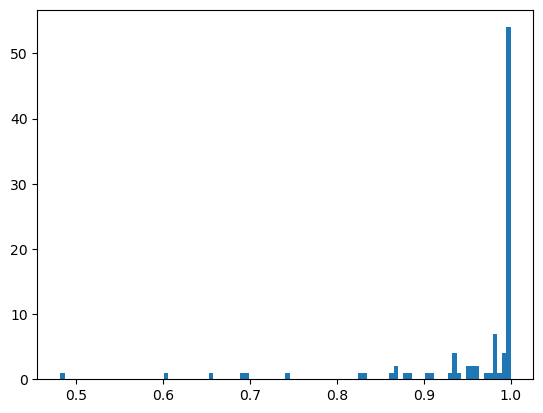

In [27]:
plt.hist(maxes, bins=100)
plt.show()

In [28]:
plt.boxplot(maxes)
# plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x19980175e50>,
 'caps': [<matplotlib.lines.Line2D at 0x199801cc310>,
 'boxes': [<matplotlib.lines.Line2D at 0x19980175a60>],
 'medians': [<matplotlib.lines.Line2D at 0x199801ccb20>],
 'fliers': [<matplotlib.lines.Line2D at 0x199801ccc10>],
 'means': []}